In [1]:
# Mengimpor library
import re
import locale

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from joblib import delayed
from joblib import Parallel

from scipy.cluster.hierarchy import ward, dendrogram, fcluster

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Data Understanding

In [2]:
# Menyiapkan format bahasa dan mengunduh dictionary
locale.setlocale(locale.LC_ALL, '')
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to /home/fahmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fahmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Kumpulan stopwords
stopwords_list = set(stopwords.words('english') + ['AT_USER', 'URL'])
stemmer = SnowballStemmer(language='english')

In [4]:
# membaca data dari file CSV
newsgroups_all = fetch_20newsgroups(subset='all', categories=["sci.electronics", "sci.med", "sci.space"], remove=('headers', 'footers', 'quotes'), random_state=42)

In [5]:
print("Total data:", len(newsgroups_all.data))
print("Sampel berita:", newsgroups_all.data[0])

Total data: 2961
Sampel berita: I live at sea-level, and am called-upon to travel to high-altitude cities
quite frequently, on business.  The cities in question are at 7000 to 9000
feet of altitude.  One of them especially is very polluted...

Often I feel faint the first two or three days.  I feel lightheaded, and
my heart seems to pound a lot more than at sea-level.  Also, it is very
dry in these cities, so I will tend to drink a lot of water, and keep
away from dehydrating drinks, such as those containing caffeine or alcohol.

Thing is, I still have symptoms.  How can I ensure that my short trips there
(no, I don't usually have a week to acclimatize) are as comfortable as possible?
Is there something else that I could do?

A long time ago (possibly two years ago) there was a discussion here about
altitude adjustment.  Has anyone saved the messages?

Many thanks,


## Data Preparation

In [6]:
# Fungsi untuk melakukan pembersihan teks
def preprocess_text(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'AT_USER', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stopwords_list and word.isalpha()]
    text = [stemmer.stem(word) for word in text]
    return ' '.join(text)

texts = Parallel(n_jobs=4, batch_size=128, verbose=10)(delayed(preprocess_text)(text) for text in newsgroups_all.data)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 648 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1288 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 2184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 2366 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 2566 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 2647 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 2865 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 2961 out of 2961 | elapsed:    2.2s finished


[('use', 2042), ('would', 1686), ('one', 1666), ('get', 1185), ('space', 1128), ('like', 1115), ('also', 983), ('time', 943), ('know', 872), ('could', 774)]


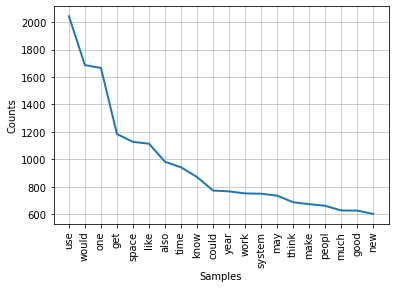

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [7]:
# Membuat korpus kata-kata umum
freqdist = FreqDist()
for sentence in texts:
    for word in word_tokenize(sentence):
        freqdist[word] += 1

# Visualisasi frekuensi kata-kata umum
print(freqdist.most_common(10))
freqdist.plot(20, cumulative=False)

## Modelling

In [8]:
# Membuat model
pipeline = Pipeline([
    ('tfidf-vectorize', TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2, use_idf=True, max_features=10000)),
    ('lsa-reduce', TruncatedSVD(n_components=3))
])

projections = pipeline.fit_transform(texts)
tfidf_matrix = pipeline.steps[0][1].transform(texts)

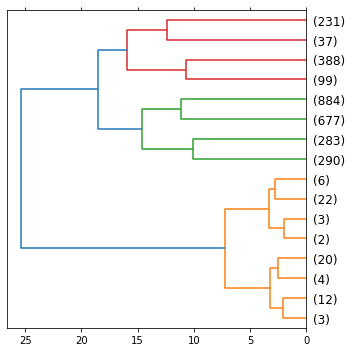

In [9]:
dist = 1 - cosine_similarity(tfidf_matrix)
linkage_matrix = ward(dist)
cluster_labels = fcluster(linkage_matrix, 3, criterion='maxclust')

fig, ax = plt.subplots(figsize=(5, 5))
ax = dendrogram(linkage_matrix, orientation="left", labels=cluster_labels, p=3, truncate_mode="level");

plt.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
plt.tight_layout()

## Evaluation

In [10]:
df = pd.DataFrame({
    'text': texts,
    'true_label': newsgroups_all.target,
    'pred_label': cluster_labels
})

In [11]:
print("Davies-Bouldin score (true):", davies_bouldin_score(projections, df['true_label']))
print("Davies-Bouldin score (pred):", davies_bouldin_score(projections, df['pred_label']))
print("Silhouette score (true):", silhouette_score(projections, df['true_label']))
print("Silhouette score (pred):", silhouette_score(projections, df['pred_label']))

Davies-Bouldin score (true): 2.0558400840964404
Davies-Bouldin score (pred): 1.5297376184744966
Silhouette score (true): 0.04501789231145201
Silhouette score (pred): 0.3106833539228856


Cluster: 0
Kata populer: [('bank', 73), ('gordon', 72), ('skeptic', 70), ('chastiti', 70), ('intellect', 70)]
Cluster: 1
Kata populer: [('use', 1178), ('one', 913), ('would', 900), ('get', 639), ('like', 616)]
Cluster: 2
Kata populer: [('space', 994), ('use', 855), ('would', 775), ('one', 734), ('launch', 520)]


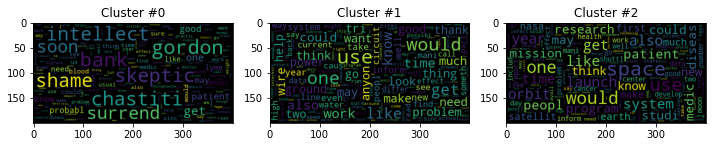

In [12]:
plt.figure(figsize=(10, 7))
for cluster_i in range(3):
    cluster_i_data = df[df['pred_label'] == cluster_i + 1]

    freqdist = FreqDist()
    for sentence in cluster_i_data['text']:
        for word in word_tokenize(sentence):
            freqdist[word] += 1
    
    print("Cluster:", cluster_i)
    print("Kata populer:", freqdist.most_common(5))

    wc = WordCloud(max_font_size=40).generate_from_frequencies(freqdist)
    ax = plt.subplot(1, 3, cluster_i + 1)
    ax.imshow(wc)
    ax.set_title("Cluster #%d" % cluster_i)

plt.tight_layout()
plt.show()

Text(0.5, 0, 'PC3')

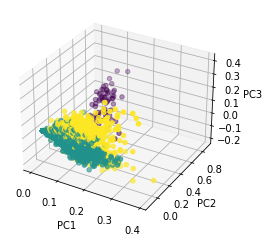

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(projections[:, 0], projections[:, 1], projections[:, 2], c=cluster_labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

Text(0.5, 0, 'PC3')

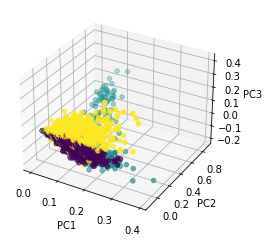

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(projections[:, 0], projections[:, 1], projections[:, 2], c=newsgroups_all.target)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')